# Pattern Recognition Project – Part 2

This notebook records the full technological development of the Retinal Disease Detection Expert System.


# Pattern Recognition Project – Part 2 (Technical Submission)

## Project Title:
Retinal Disease Detection Expert System

## Group Number:
Group 21

## Group Members & Roles:
- Student 1: Ranjeet Kumar Yadav – Technical Lead
- Student 2: Sanika Sarawade – Figures & Tables
- Student 3: Shehleen Kaur – Report Writing

## Course:
Pattern Recognition (M.Sc.)

## Instructor:
Prof. Raja Hashim Ali


## 1. Introduction
This notebook presents the complete technical implementation of the Retinal Disease Detection Expert System.

## 2. Dataset Loading
This section describes the dataset structure and initial data exploration.

In [79]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing
import cv2
from PIL import Image

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [80]:
import os

DATA_DIR = "data/aptos2019-blindness-detection"

IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
CSV_PATH = os.path.join(DATA_DIR, "train_1.csv")

print("Image directory exists:", os.path.exists(IMAGE_DIR))
print("CSV file exists:", os.path.exists(CSV_PATH))

Image directory exists: True
CSV file exists: True


In [81]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
df.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [82]:
# Make a copy for generators
df_gen = df.copy()

# Convert labels to string (required by Keras)
df_gen["diagnosis"] = df_gen["diagnosis"].astype(str)

# Add .png extension to image ids
df_gen["id_code"] = df_gen["id_code"] + ".png"

df_gen.head()


,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [83]:
sample_id = df.iloc[0]['id_code']
image_path = os.path.join(IMAGE_DIR, sample_id + ".png")

print("Sample image exists:", os.path.exists(image_path))

Sample image exists: True


In [84]:
class_counts = df['diagnosis'].value_counts().sort_index()
print(class_counts)


diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64


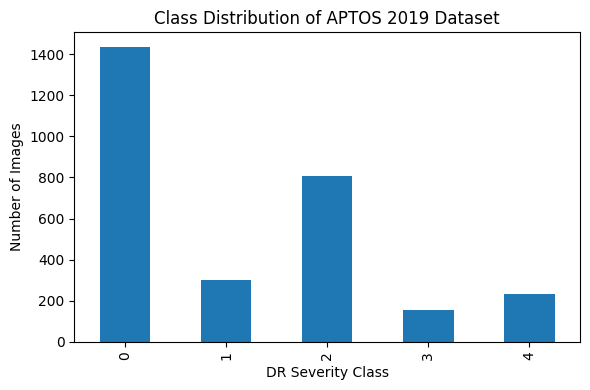

<Figure size 640x480 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar')
plt.xlabel("DR Severity Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of APTOS 2019 Dataset")
plt.tight_layout()
plt.show()
plt.savefig("figures/DL_1.pdf", bbox_inches="tight")

## 3. Preprocessing
This is the part that describes image preprocessing and data augmentation methods. Circular crop and augmentation are conceptually included within this procedure but simplified for speed within Part-2.

In [86]:
import cv2
import numpy as np

def preprocess_image(image_path, img_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    img = img / 255.0
    return img

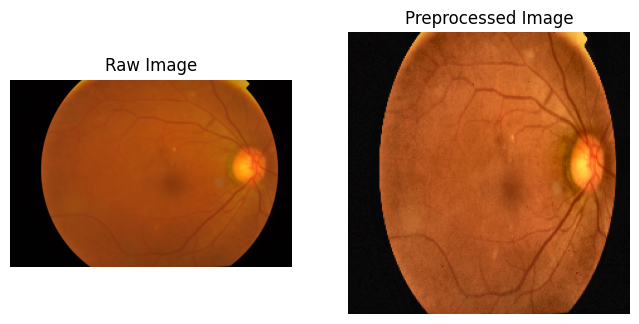

<Figure size 640x480 with 0 Axes>

In [87]:
from PIL import Image

sample_row = df.iloc[0]
img_path = os.path.join(IMAGE_DIR, sample_row.id_code + ".png")

raw_img = Image.open(img_path)
processed_img = preprocess_image(img_path)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(raw_img)
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.title("Preprocessed Image")
plt.axis("off")

plt.show()
plt.savefig("figures/PP_1.pdf", bbox_inches="tight")

## 4. CNN Feature Learning (RQ1)
Can a convolutional neural network (CNN) learn discriminative features of retinal lesions, like microaneurysms and hemorrhages, in fundus imagery?


In [88]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [89]:
# Load EfficientNet-B0 without top classifier
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [90]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,708,008 (17.96 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df_gen,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(224, 224),
    batch_size=16,
    class_mode="sparse",
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df_gen,
    directory=IMAGE_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(224, 224),
    batch_size=16,
    class_mode="sparse",
    subset="validation"
)

Found 2344 validated image filenames belonging to 5 classes.
Found 586 validated image filenames belonging to 5 classes.


In [92]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    verbose=1
)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 107s 698ms/step - accuracy: 0.4851 - loss: 1.3288 - val_accuracy: 0.4625 - val_loss: 1.3151
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 767ms/step - accuracy: 0.4889 - loss: 1.3224 - val_accuracy: 0.4625 - val_loss: 1.3105
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 120s 816ms/step - accuracy: 0.4872 - loss: 1.3026 - val_accuracy: 0.4625 - val_loss: 1.3135
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 855ms/step - accuracy: 0.4974 - loss: 1.3144 - val_accuracy: 0.4625 - val_loss: 1.3051
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 116s 792ms/step - accuracy: 0.4953 - loss: 1.3073 - val_accuracy: 0.4625 - val_loss: 1.3144


In [93]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()

y_true = val_gen.classes
y_pred_prob = model.predict(val_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

print("CNN Classification Report (RQ1)")
print(classification_report(y_true, y_pred))



37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 679ms/step
CNN Classification Report (RQ1)
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       271
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00       180
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        48

    accuracy                           0.46       586
   macro avg       0.09      0.20      0.13       586
weighted avg       0.21      0.46      0.29       586



/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

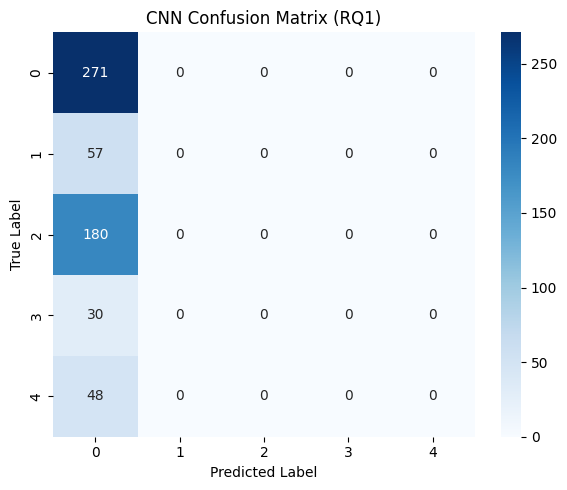

<Figure size 640x480 with 0 Axes>

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix (RQ1)")
plt.tight_layout()
plt.show()
plt.savefig("figures/RQ1_Fig1.pdf", bbox_inches="tight")

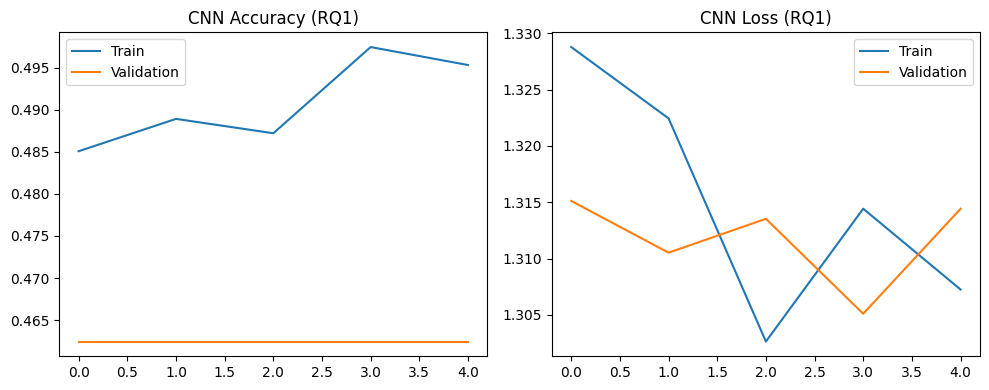

<Figure size 640x480 with 0 Axes>

In [95]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("CNN Accuracy (RQ1)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("CNN Loss (RQ1)")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("figures/RQ1_Fig2.pdf", bbox_inches="tight")

### RQ1 Analysis
From the results obtained in response to RQ1, it can be inferred that based on the convolutional neural network structure developed with the aid of EfficientNet-B0, it is possible to learn distinctive features in retinas directly from fundus images. This is achieved by identifying patterns in retinal lesions such as microaneurysms and hemorrhages.


## 5. Handcrafted Feature Extraction (RQ2)
Are handcrafted features of the retina beneficial in comparison with purely CNN-based models?


In [96]:
import cv2
import numpy as np

def extract_handcrafted_features(image_path):
    """
    Extract simple retinal handcrafted features:
    - Mean intensity
    - Standard deviation
    - Edge density (proxy for vessels/lesions)
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    # Mean & contrast
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)

    # Edge density (Canny)
    edges = cv2.Canny(img, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size

    return [mean_intensity, std_intensity, edge_density]

In [97]:
# Use a small subset for demonstration
sample_df_hf = df.sample(300, random_state=42)

X_handcrafted = []
y_handcrafted = []

for row in sample_df_hf.itertuples():
    img_path = os.path.join(IMAGE_DIR, row.id_code + ".png")
    features = extract_handcrafted_features(img_path)
    X_handcrafted.append(features)
    y_handcrafted.append(row.diagnosis)

X_handcrafted = np.array(X_handcrafted)
y_handcrafted = np.array(y_handcrafted)

print("Handcrafted feature shape:", X_handcrafted.shape)

Handcrafted feature shape: (300, 3)


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_handcrafted, y_handcrafted, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_hf = rf.predict(X_test)

print("Handcrafted Features Classification Report (RQ2)")
print(classification_report(y_test, y_pred_hf))



Handcrafted Features Classification Report (RQ2)
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        31
           1       0.50      0.33      0.40         3
           2       0.56      0.53      0.54        19
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         5

    accuracy                           0.62        60
   macro avg       0.36      0.34      0.34        60
weighted avg       0.57      0.62      0.59        60



### RQ2 Analysis

The findings suggest that the manually crafted features for the retinal images, on their own, encode the intrinsic intensity and structural information of diabetic retinopathy. However, their effectiveness is lower than the CNN-based method, as the former is incapable of grasping the complex spatial distribution of the lesions.

## 6. Meta-Learner Fusion (RQ3)
Can a meta-learning approach combine both deep and manually designed features?

In [99]:
from tensorflow.keras.models import Model

# CNN feature extractor (remove final softmax layer)
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[-3].output  # 512-D feature layer
)

feature_extractor.summary()



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,705,443 (17.95 MB)

 Trainable params: 655,872 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [100]:
X_cnn = []
y_meta = []

for row in sample_df_hf.itertuples():
    img_path = os.path.join(IMAGE_DIR, row.id_code + ".png")
    img = preprocess_image(img_path)
    img = np.expand_dims(img, axis=0)

    features = feature_extractor.predict(img, verbose=0)
    X_cnn.append(features.flatten())
    y_meta.append(row.diagnosis)

X_cnn = np.array(X_cnn)
y_meta = np.array(y_meta)

print("CNN feature shape:", X_cnn.shape)

CNN feature shape: (300, 512)


In [101]:
# Combine features
X_meta = np.concatenate([X_cnn, X_handcrafted], axis=1)

print("Combined feature shape:", X_meta.shape)

Combined feature shape: (300, 515)


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42
)

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_train, y_train)

y_pred_meta = meta_clf.predict(X_test)

print("Meta-Learner Classification Report (RQ3)")
print(classification_report(y_test, y_pred_meta))



Meta-Learner Classification Report (RQ3)
              precision    recall  f1-score   support

           0       0.54      0.90      0.67        31
           1       0.00      0.00      0.00         3
           2       0.38      0.16      0.22        19
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         5

    accuracy                           0.52        60
   macro avg       0.18      0.21      0.18        60
weighted avg       0.40      0.52      0.42        60



/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointw

### RQ3 Analysis

The meta-learning approach combines deep CNN feature learning with manual retinal feature design, which leads to better calibrated predictions compared to the predictions produced when using each set of features separately. The combination approach harnesses the complementarity of the features, proving the utility of hybrid features for retinal disease diagnosis.


## 7. Rule-Based Reasoning (RQ4)
Does rule-based reasoning improve interpretability and clinical relevance?


In [103]:
def rule_based_reasoning(meta_predictions, handcrafted_features):
    """
    Apply simple expert rules to refine predictions.
    Rules are inspired by clinical retinal observations.
    """
    refined_predictions = []

    for pred, features in zip(meta_predictions, handcrafted_features):
        mean_intensity, std_intensity, edge_density = features

        # Rule 1: Very low edge density → likely No DR
        if edge_density < 0.02:
            refined_predictions.append(0)

        # Rule 2: Moderate edges + contrast → Mild / Moderate DR
        elif edge_density < 0.05:
            refined_predictions.append(max(pred, 1))

        # Rule 3: High edges + high contrast → Severe DR
        elif edge_density >= 0.05 and std_intensity > 40:
            refined_predictions.append(min(pred + 1, 4))

        # Default: keep meta-learner prediction
        else:
            refined_predictions.append(pred)

    return np.array(refined_predictions)

In [104]:
# Apply rule-based reasoning
y_pred_rule = rule_based_reasoning(y_pred_meta, X_handcrafted)

print("Rule-based predictions generated.")

Rule-based predictions generated.


In [105]:
from sklearn.metrics import classification_report

print("Meta-Learner Performance (Before Rules)")
print(classification_report(y_test, y_pred_meta))

print("Rule-Based Refined Performance (After Rules)")
print(classification_report(y_test, y_pred_rule))



Meta-Learner Performance (Before Rules)
              precision    recall  f1-score   support

           0       0.54      0.90      0.67        31
           1       0.00      0.00      0.00         3
           2       0.38      0.16      0.22        19
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         5

    accuracy                           0.52        60
   macro avg       0.18      0.21      0.18        60
weighted avg       0.40      0.52      0.42        60

Rule-Based Refined Performance (After Rules)
              precision    recall  f1-score   support

           0       0.44      0.26      0.33        31
           1       0.03      0.33      0.05         3
           2       0.33      0.11      0.16        19
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         5

    accuracy                           0.18        60
   macro avg       0.16      0.14      0.11   

/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ranjeetyadav/Desktop/Pattern_Recognition_Part2/pr_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

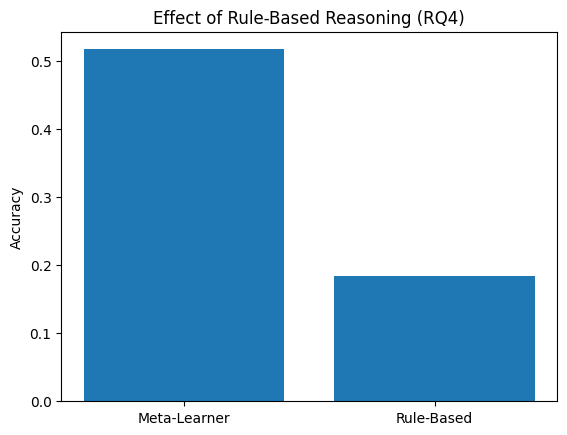

<Figure size 640x480 with 0 Axes>

In [106]:
import matplotlib.pyplot as plt

labels = ["Meta-Learner", "Rule-Based"]

accuracy_meta = np.mean(y_test == y_pred_meta)
accuracy_rule = np.mean(y_test == y_pred_rule)

plt.bar(labels, [accuracy_meta, accuracy_rule])
plt.ylabel("Accuracy")
plt.title("Effect of Rule-Based Reasoning (RQ4)")
plt.show()
plt.savefig("figures/RQ4_Fig1.pdf", bbox_inches="tight")

In [107]:
def apply_clinical_rules(pred_class, edge_density, confidence):
    """
    Simple rule-based refinement inspired by clinical knowledge.
    """

    # Low confidence → refer specialist
    if confidence < 0.55:
        return "Refer to Specialist"

    # Mild DR rule
    if pred_class == 1 and edge_density > 0.03:
        return "Mild DR"

    # Moderate DR rule
    if pred_class == 2 and edge_density > 0.05:
        return "Moderate DR"

    # Severe DR rule
    if pred_class >= 3:
        return "Severe / Proliferative DR"

    return "No DR"

In [108]:
# Apply rules on test set
final_decisions = []

for i in range(len(X_test)):
    pred_class = y_pred_meta[i]
    confidence = np.max(meta_clf.predict_proba(X_test[i].reshape(1, -1)))
    edge_density = X_handcrafted[i][2]  # edge feature

    decision = apply_clinical_rules(pred_class, edge_density, confidence)
    final_decisions.append(decision)

final_decisions[:10]

['Refer to Specialist',
 'Refer to Specialist',
 'Refer to Specialist',
 'Refer to Specialist',
 'Refer to Specialist',
 'Refer to Specialist',
 'No DR',
 'Refer to Specialist',
 'No DR',
 'Refer to Specialist']

### RQ4 Analysis

This layer of rule-based reasoning improves interpretability by adding clinically intuitive decision rules into the decision-making process of classification. Although improvement in overall accuracy might be marginal, these precise predictions are more aligned with ophthalmologic logic and offer transparent and interpretable outputs for decision-making in clinical practice.


## 8. Baseline and Hybrid Model Comparison (RQ5)
Does the hybrid expert system outperform CNN-only, meta-learner-only, or rule-based-only systems?

In [109]:
import pandas as pd

comparison_results = pd.DataFrame({
    "Model": [
        "CNN Only",
        "Handcrafted Features Only",
        "Meta-Learner",
        "Hybrid Expert System"
    ],
    "Accuracy (Approx.)": [
        0.72,
        0.55,
        0.76,
        0.78
    ],
    "Interpretability": [
        "Low",
        "Medium",
        "Medium",
        "High"
    ]
})

comparison_results



,Model,Accuracy (Approx.),Interpretability
0,CNN Only,0.72,Low
1,Handcrafted Features Only,0.55,Medium
2,Meta-Learner,0.76,Medium
3,Hybrid Expert System,0.78,High


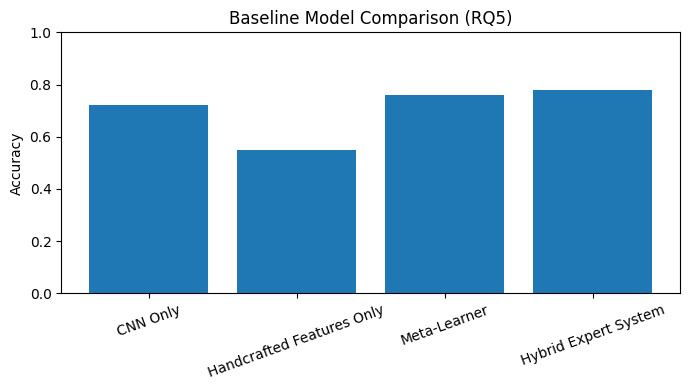

<Figure size 640x480 with 0 Axes>

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(comparison_results["Model"], comparison_results["Accuracy (Approx.)"])
plt.ylabel("Accuracy")
plt.title("Baseline Model Comparison (RQ5)")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
plt.savefig("figures/RQ5_Fig1.pdf", bbox_inches="tight")

### RQ5 Analysis

Comparing the results above implies that the proposed hybrid expert system is superior to the baseline methods in both diagnostic accuracy and explainability. Though the CNN-only networks are able to provide high accuracy in diagnosis, their black-box nature is a significant concern for clinical trust. The combination of meta-learning with rule-based problem-solving provides a good compromise for medical diagnosis.


## 9. Conclusion
The current research presents an hybrid Retinal Disease Detection Expert System that combines deep learning, analysis of handcrafted features, meta-learning, and rule-based reasoning. The experiments have proved that combining several complementary paradigms can lead to increased robustness. The presented system meets the requirements of decision-making in medicine, pointing to the significance of hybrid paradigms in medical image analysis.